In [1]:
import json
import os
import warnings
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize

# filepath = Path(__file__).parent
filepath = Path(os.path.abspath(''))
print(filepath)

canc_col_name = "improve_sample_id"
drug_col_name = "improve_chem_id"

/nfs/ml_lab/projects/improve/data/experiments/csa_postproc_all


In [2]:
datadir = Path('splits_averaged')
filename = 'all_models_scores.csv'
# outdir = Path('Plots')
# os.makedirs(outdir, exist_ok=True)
outdir = datadir

model_name_mapping = {
    "deepcdr": "DeepCDR",
    "graphdrp": "GraphDRP",
    "hidra": "HiDRA",
    "lgbm": "LGBM",
    "tcnns": "tCNNS",
    "uno": "UNO",
}

df = pd.read_csv(filepath / datadir / filename, sep=',')
all_scores = df.copy()
df.iloc[:3,:]

,met,split,value,src,trg,model
0,mse,0,0.006295,CCLE,CCLE,deepcdr
1,mse,1,0.005950,CCLE,CCLE,deepcdr
2,mse,2,0.005129,CCLE,CCLE,deepcdr


In [3]:
# Average across splits
sc_mean = df.groupby(['met', 'src', 'trg', 'model'])['value'].mean().reset_index()
sc_std = df.groupby(['met', 'src', 'trg', 'model'])['value'].std().reset_index()
sc_mean[:3]

,met,src,trg,model,value
0,mse,CCLE,CCLE,deepcdr,0.006063
1,mse,CCLE,CCLE,graphdrp,0.006577
2,mse,CCLE,CCLE,hidra,0.006309


In [4]:
# filtered_data[:50]

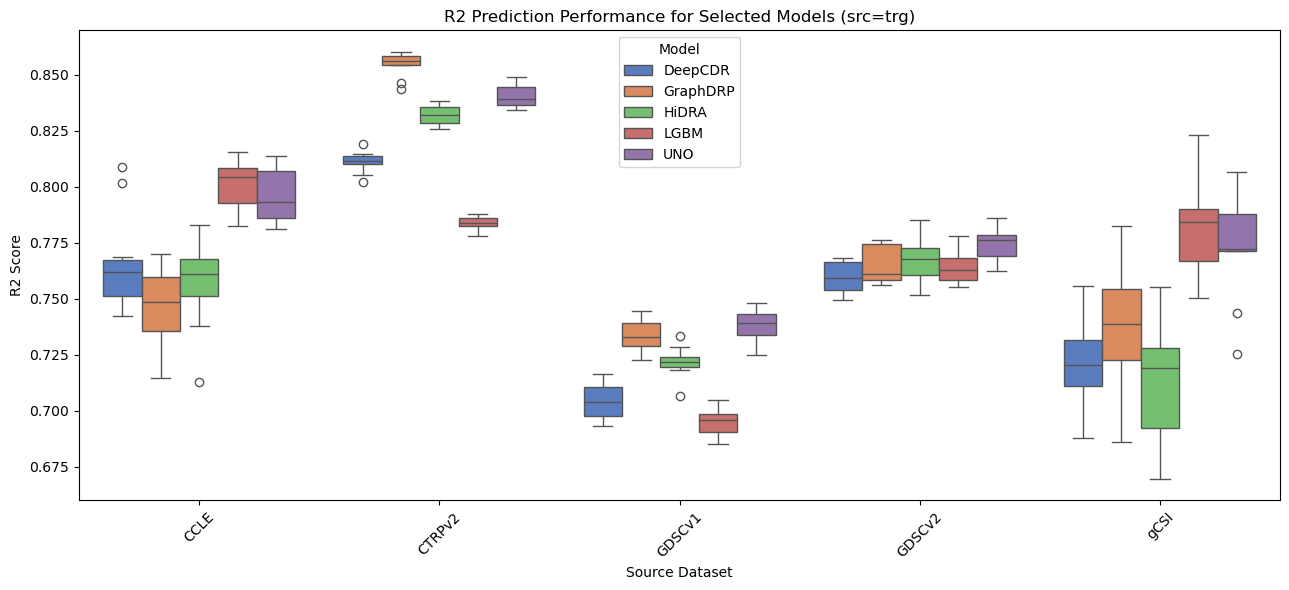

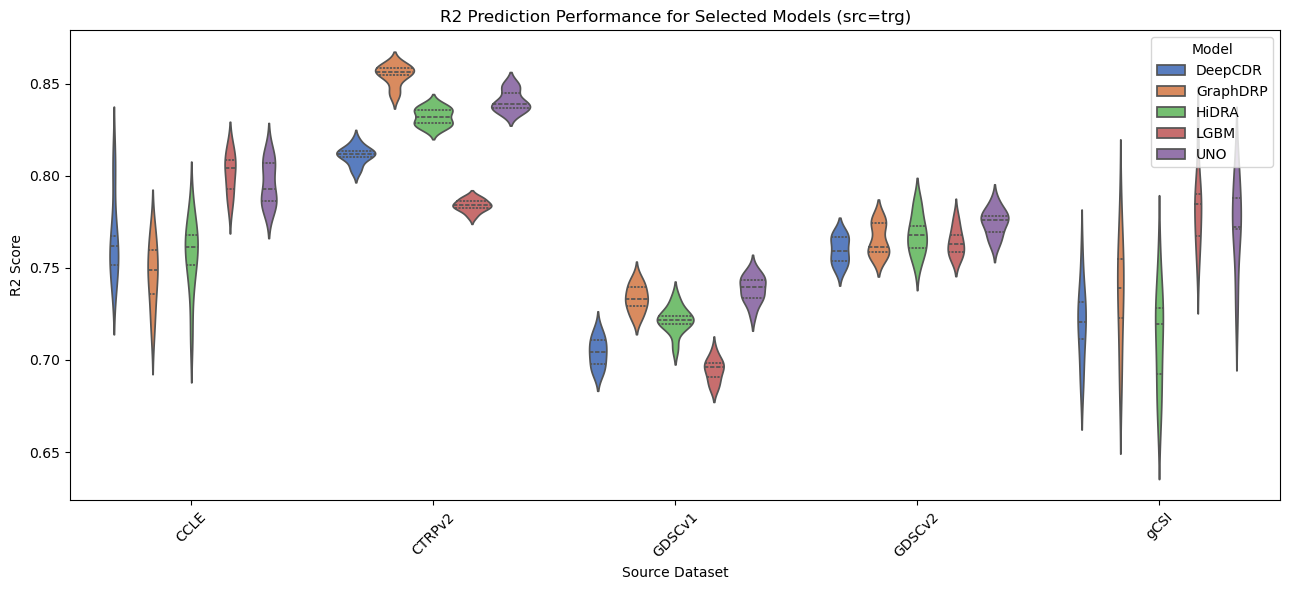

In [5]:
# ------------------------------------------------------------------------------------------------
## Performance Distribution Across Splits (src = trg)
# Multiple models, single metric, src = trg
# Box plot, violin plot
# ------------------------------------------------------------------------------------------------

metric_name = "r2"

# Specify the models you want to include
models_to_include = []  # Replace with your desired models
models_to_include = ["deepcdr", "graphdrp", "hidra", "lgbm", "uno"]  # Replace with your desired models
# models_to_include = ["graphdrp"]  # Replace with your desired models

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

filtered_data = all_scores[
    (all_scores["model"].isin(models_to_include)) & 
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])
].reset_index(drop=True)

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

# Plot settings
# palette = "Set3"
palette = "muted"
title = f"{metric_name.upper()} Prediction Performance for Selected Models (src=trg)"
ylabel = f"{metric_name.upper()} Score"
xlabel = "Source Dataset"
xlabel_rotation = 45

# Plot: Boxplot for Each Source Dataset (src=trg)
plt.figure(figsize=(13, 6))
if len(models_to_include) == 1:
    sns.boxplot(data=filtered_data, x="src", y="value", palette=palette, legend=False)
else:
    sns.boxplot(data=filtered_data, x="src", y="value", hue="model", palette=palette, legend=True)
    plt.legend(title='Model')
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(rotation=xlabel_rotation)
plt.tight_layout()
plt.savefig(outdir / f"boxplot_{metric_name}_within_study_multiple_models.png")  # Save boxplot
plt.show()

# Plot: Violin Plot for Each Source Dataset (src=trg)
plt.figure(figsize=(13, 6))
if len(models_to_include) == 1:
    sns.violinplot(data=filtered_data, x="src", y="value", palette=palette, inner="quartile")
else:
    sns.violinplot(data=filtered_data, x="src", y="value", hue="model", palette=palette, inner="quartile", dodge=True)
    plt.legend(title='Model')
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(rotation=xlabel_rotation)
plt.tight_layout()
plt.savefig(outdir / f"violinplot_{metric_name}_within_study_multiple_models.png")  # Save violinplot
plt.show()

/tmp/ipykernel_1620450/3337652319.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].map(model_name_mapping)


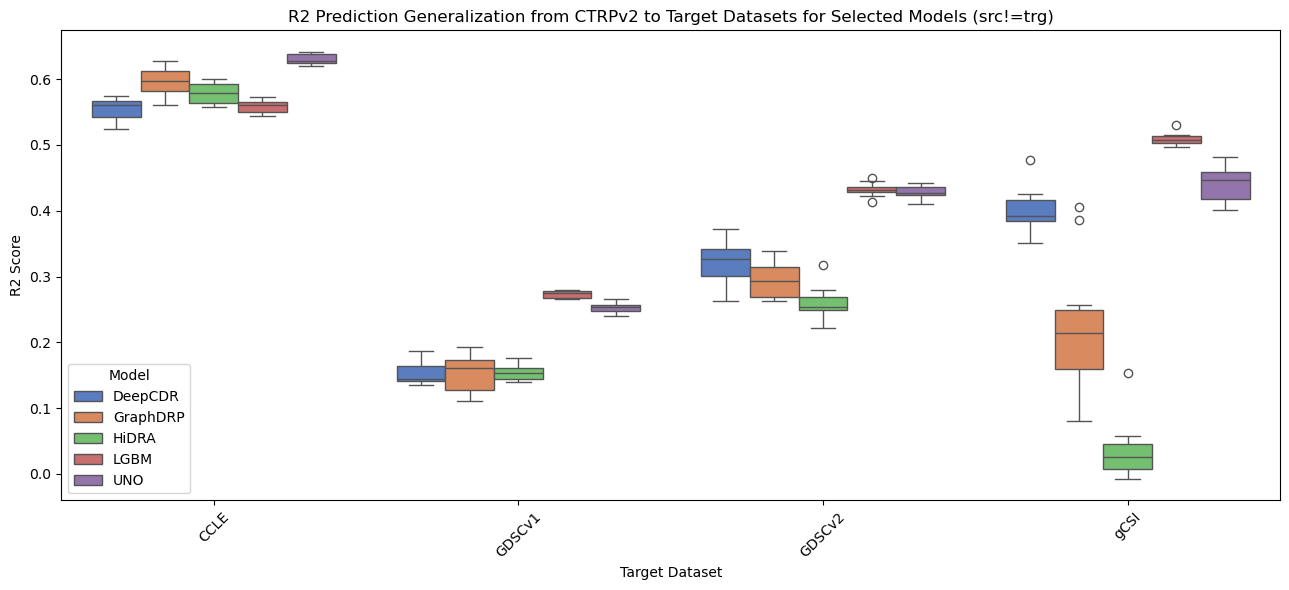

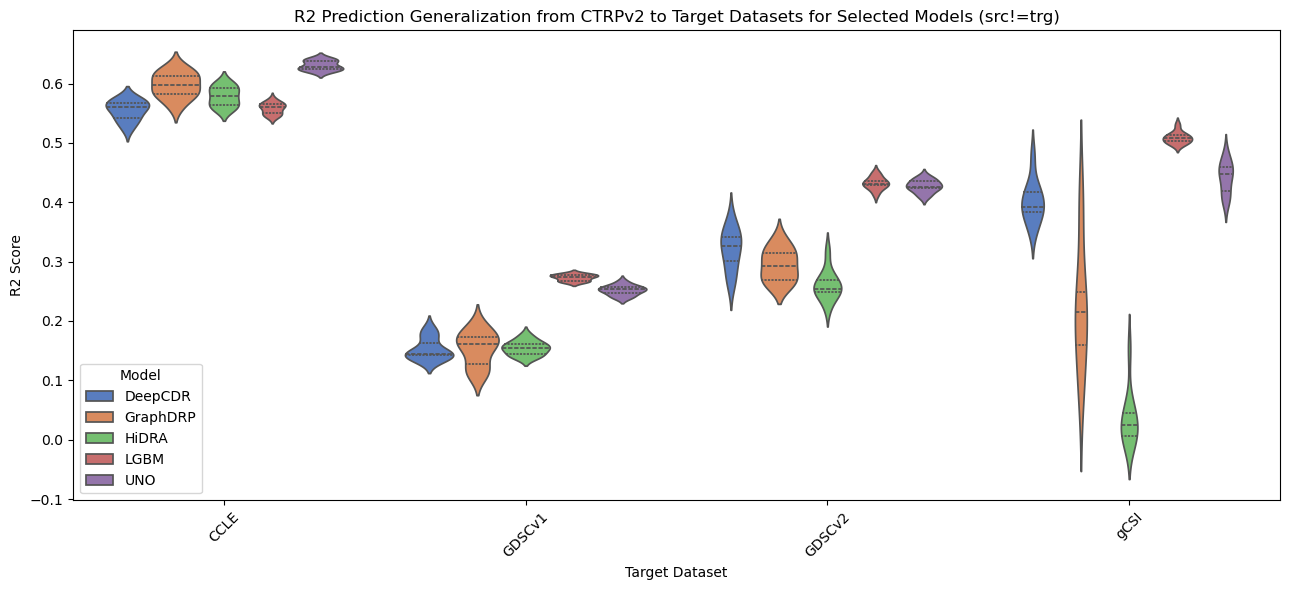

In [6]:
# ------------------------------------------------------------------------------------------------
## Performance Distribution Across Targets (src != trg)
# Multiple models, single metric, src != trg
# Box plot, violin plot
# ------------------------------------------------------------------------------------------------

# Specify the metric name and source dataset for filtering
metric_name = "r2"  # Replace with the desired metric
source_dataset = "CTRPv2"  # Replace with the specific source dataset

# Specify the models you want to include
models_to_include = []  # Replace with your desired models
models_to_include = ["deepcdr", "graphdrp", "hidra", "lgbm", "uno"]  # Replace with your desired models
# models_to_include = ["graphdrp"]  # Replace with your desired models

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

# Filter data for specific source dataset (src = CTRPv2), and R^2 metric
filtered_data = all_scores[
    (all_scores["src"] == source_dataset) &
    (all_scores["src"] != all_scores["trg"]) &  # Exclude cases where src = trg
    (all_scores["met"] == metric_name) &
    (all_scores["model"].isin(models_to_include))  # Include only specified models
]

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

# Plot settings
# palette = "Set3"
palette = "muted"
title = f"{metric_name.upper()} Prediction Generalization from {source_dataset} to Target Datasets for Selected Models (src!=trg)"
ylabel = f"{metric_name.upper()} Score"
xlabel = "Target Dataset"
xlabel_rotation = 45

# Plot: Boxplot for Each Target Dataset (src != trg)
plt.figure(figsize=(13, 6))
# sns.boxplot(data=filtered_data, x="trg", y="value", hue="model", palette=palette)
if len(models_to_include) == 1:
    sns.boxplot(data=filtered_data, x="trg", y="value", palette=palette, legend=False)
else:
    sns.boxplot(data=filtered_data, x="trg", y="value", hue="model", palette=palette, legend=True)
    plt.legend(title='Model')
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(rotation=xlabel_rotation)
plt.tight_layout()

# Save the boxplot
plt.savefig(outdir / f"boxplot_{metric_name}_cross_study_from_{source_dataset}_to_targets.png")  # Save boxplot
plt.show()

# Plot: Violin Plot for Each Target Dataset (src != trg)
plt.figure(figsize=(13, 6))
if len(models_to_include) == 1:
    sns.violinplot(data=filtered_data, x="trg", y="value", palette=palette, inner="quartile")
else:
    sns.violinplot(data=filtered_data, x="trg", y="value", hue="model", palette=palette, inner="quartile", dodge=True)
    plt.legend(title='Model')
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(rotation=xlabel_rotation)
plt.tight_layout()

# Save the violin plot
plt.savefig(outdir / f"violin_plot_{metric_name}_cross_study_from_{source_dataset}_to_targets.png")  # Save violinplot
plt.show()

In [ ]:
# ------------------------------------------------------------------------------------------------
## Basic CSA Table
# Single model, single metric
# Using Seaborn
# ------------------------------------------------------------------------------------------------

datadir = Path('splits_averaged')
mean_csa_filename = 'graphdrp_r2_mean_csa_table.csv'
std_csa_filename = 'graphdrp_r2_std_csa_table.csv'

scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
std_csa_data = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

scores_csa_data.set_index("src", inplace=True)
std_csa_data.set_index("src", inplace=True)

display(scores_csa_data)
display(std_csa_data)

In [ ]:
# ------------------------------------------------------------------------------------------------
## CSA Performance Scores with Standard Deviations (Linear Scale)
# ------------------------------------------------------------------------------------------------

# Define colormap
cmap = sns.color_palette("Blues", as_cmap=True)

# Use Normalize to ensure linear scaling
threshold = -0.5  # Values <= -0.5 will be deep blue
norm = Normalize(vmin=threshold, vmax=1)

# Combine scores and stds for annotations
combined_annotations = scores_csa_data.round(4).astype(str) + "\n(" + std_csa_data.round(4).astype(str) + ")"

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    scores_csa_data, 
    annot=combined_annotations.values,
    fmt="", 
    cmap=cmap, 
    norm=norm, 
    cbar_kws={'label': 'R² Score'}
)

# Customize colorbar ticks
colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([threshold, 0, 0.5, 1])
colorbar.set_ticklabels([f"≤ {threshold}", "0", "0.5", "1"])

# Finalize plot
plt.title("CSA Performance Scores with Standard Deviations (Linear Scale)")
plt.xlabel("Target Dataset")
plt.ylabel("Source Dataset")
plt.tight_layout()
plt.show()


In [9]:
# # ------------------------------------------------------------------------------------------------
# ## CSA Performance Scores with Standard Deviations (Discrete Levels Same Color)
# # ------------------------------------------------------------------------------------------------

# # Define discrete levels and custom colormap
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]
# colors = ["#08306b", "#2171b5", "#6baed6", "#bdd7e7", "#eff3ff"]
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Combine scores and stds for annotations
# combined_annotations = scores_csa_data.round(4).astype(str) + "\n(" + std_csa_data.round(4).astype(str) + ")"

# # Plot the combined heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(
# scores_csa_data, 
#     annot=combined_annotations.values, 
#     fmt="", 
#     cmap=cmap, 
#     norm=norm, 
#     cbar_kws={'label': 'R² Score'}
# )

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

In [10]:
# # ------------------------------------------------------------------------------------------------
# ## CSA Performance Scores with Standard Deviations (Discrete Levels Different Colors)
# # ------------------------------------------------------------------------------------------------

# # Define custom levels and pale colors
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]  # Replace -float("inf") with a very small value
# colors = ["#dcd0ff", "#ffd1d1", "#ffebcc", "#ffffcc", "#d1ffd1"]  # Pale purple, red, orange, yellow, green
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Plot heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(scores_csa_data, annot=True, fmt=".2f", cmap=cmap, norm=norm, cbar_kws={'label': 'R² Score'})

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# # Finalize plot
# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

# Custom metrics

In [ ]:
# # Example CSA scores (R²)
# scores_data = {
#     "CCLE": [0.7479, 0.5758, 0.4482, 0.3082, 0.0234],
#     "CTRPv2": [-0.4671, 0.8508, -0.1432, -0.0324, -1.1319],
#     "GDSCv1": [-0.2057, 0.1503, 0.734, 0.154, -0.4801],
#     "GDSCv2": [-0.2913, 0.2902, 0.2003, 0.7659, -0.7147],
#     "gCSI": [-0.3793, 0.2314, 0.4179, 0.3914, 0.733],
# }
# scores = pd.DataFrame(scores_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

# # Example CSA std deviations (optional for some metrics)
# stds_data = {
#     "CCLE": [0.0123, 0.0406, 0.0245, 0.0364, 0.1058],
#     "CTRPv2": [0.0249, 0.0031, 0.0135, 0.0253, 0.0901],
#     "GDSCv1": [0.078, 0.0301, 0.0065, 0.0389, 0.0304],
#     "GDSCv2": [0.0453, 0.0216, 0.0262, 0.0098, 0.0448],
#     "gCSI": [0.1053, 0.1546, 0.0903, 0.1144, 0.0314],
# }
# stds = pd.DataFrame(stds_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

scores = scores_csa_data.copy()
stds = std_csa_data.copy()
display(scores)
display(stds)

# Source-to-Target Generalization Ratio (STGR)

In [ ]:
# Source-Target Generalization Ratio (STG-R)
"""
The STGR quantifies the relative performance of a model trained on a source dataset and
applied to a target dataset. It provides a pairwise comparison by normalizing each 
source-target performance score by the source-source performance.

STGR evaluates generalization quality per source-target pair, informing on dataset 
alignments and model transferability.

Key Characteristics:
    - Pairwise Analysis/Metric: Each score S[i, j] is divided by the within-study performance S[i, i],
        providing insights into source-target performance for each dataset pair.
    - No Aggregation: Retains all normalized values, making it suitable for detailed analysis of
        cross-study generalization.
    - Generalization Insight: STGR highlights the balance between cross-study and 
        within-study performance for each pair.
    - Interpretation: 
        - STGR ≈ 1: Generalization to the target is similar to within-study performance.
        - STGR < 1: Generalization to the target is worse than within-study performance.
        - STGR > 1: Performance on the target exceeds within-study performance, possibly 
            due to target simplicity or alignment.
    - Edge Cases
        - Zero within-study performance: If scores[src, src] == 0, the result is undefined; 
            a default value of 0 is assigned.

Formula:
    STGR[i, j] = Performance(src → trg) / Performance(src → src)
    Where:
        - Performance(src → trg): Cross-study performance for source i on target j.
        - Performance(src → src): Within-study performance for source i.
"""

def compute_stgr_vectorized(scores):
    """
    Compute the Source-Target Generalization Ratio (STGR) using a vectorized approach.
    This version uses diagonal_values[:, None] for row-wise broadcasting.

    Args:
        scores (pd.DataFrame): A square DataFrame where rows represent source datasets 
            and columns represent target datasets. Each cell contains the performance 
            score for the source-target pair.

    Returns:
        pd.DataFrame: A DataFrame of STGR values.
    """
    diagonal_values = scores.to_numpy().diagonal()  # Extract within-study performances
    normalized_scores = scores.to_numpy() / diagonal_values[:, None]  # Row-wise division
    stgr = pd.DataFrame(normalized_scores, index=scores.index, columns=scores.columns)
    return stgr


def compute_stgr_bruteforce(scores):
    """
    Compute the Source-Target Generalization Ratio (STGR) using a brute-force approach.

    Args:
        scores (pd.DataFrame): A square DataFrame where rows represent source datasets 
            and columns represent target datasets. Each cell contains the performance 
            score for the source-target pair.

    Returns:
        dict: A nested dictionary where keys are source dataset names, and values are 
              dictionaries with target dataset names as keys and STGR values as values.
    """
    stgr = {}  # Initialize an empty dictionary
    diagonal_values = scores.to_numpy().diagonal()  # Extract within-study performances (diagonal values)
    
    for i, src in enumerate(scores.index):  # Iterate over source datasets
        stgr[src] = {}  # Create a nested dictionary for the source dataset
        within_study = diagonal_values[i]  # Retrieve the within-study performance for the source

        for j, trg in enumerate(scores.columns):  # Iterate over target datasets
            if within_study != 0:  # Avoid division by zero
                stgr[src][trg] = scores.iloc[i, j] / within_study  # Normalize the score for src → trg
            else:
                stgr[src][trg] = 0  # Assign STGR to 0 if within-study performance is zero

    return stgr


# Compute STGR using both implementations
stgr_bruteforce = compute_stgr_bruteforce(scores)
stgr_vectorized = compute_stgr_vectorized(scores)

# Convert bruteforce results to DataFrame for comparison
stgr_bruteforce_df = pd.DataFrame.from_dict(stgr_bruteforce, orient="index")

# Compare results
print("Bruteforce STGR:")
print(stgr_bruteforce_df)

print("\nVectorized STGR:")
print(stgr_vectorized)

# Check for equality
assert np.allclose(stgr_bruteforce_df, stgr_vectorized), "STGR results do not match!"
print("\nBoth implementations produce the same results!")


# Source-to-Target Generalization Index (STGI)

In [ ]:
# Source-to-Target Generalization Index (STG-I)
"""
The STGI evaluates the average cross-study generalization of a source dataset by 
aggregating pairwise normalized performance scores across all target datasets 
(excluding the diagonal).

STGI summarizes how well a single source dataset generalizes across many targets, 
helping to understand the intrinsic value of a dataset for training.

Key Characteristics:
    - Normalization: Each score S[i, j] is divided by the within-study performance 
        S[i, i] for the source dataset i.
    - Exclusion of Diagonal: Within-study values (S[i, i]) are excluded from the summation.
    - Generalization: STGI highlights how well a source dataset generalizes to 
        other target datasets on average {as compared to within-study performance}.
    - Aggregation: Outputs a single value for each source dataset, making it ideal for
        comparative analysis.
    - Interpretation: Higher STGI indicates better generalization from the source 
        dataset to other datasets.
        - STGI > 0: Indicates average positive generalization across other datasets.
        - STGI < 0: Suggests poor generalization performance to other datasets.
        - STGI ≈ 0: Indicates no net generalization (e.g., neutral average scores).
    - Caveats
        - Aggregation can mask pairwise nuances: Individual source-target relationships may get obscured.
        - Sensitive to dataset-specific biases: Strong performance on a subset of target datasets can dominate the average.

Formula:
    STGI[i] = (1 / (n - 1)) * Σ[j != i] (S[i, j] / S[i, i])
    Where:
        - S[i, j]: Performance of source i on target j
        - S[i, i]: Within-study performance for source i
        - n: Number of datasets (size of the scores matrix)
"""

def compute_stgi_vectorized(scores):
    """
    Compute the Source-to-Target Generalization Index (STGI) using a vectorized approach.
    This version uses diagonal_values[:, None] for row-wise broadcasting.

    Args:
        scores (pd.DataFrame): A square DataFrame where rows represent source datasets 
            and columns represent target datasets. Each cell contains the performance 
            score for the source-target pair.

    Returns:
        pd.Series: A Series of STGI values, one for each source dataset.
    """
    diagonal_values = scores.to_numpy().diagonal()  # Extract within-study performances
    normalized_scores = scores.to_numpy() / diagonal_values[:, None]  # Row-wise division

    # Set diagonal to NaN to exclude from averaging
    np.fill_diagonal(normalized_scores, np.nan)

    # Compute mean across columns (ignoring NaN) and return as Series
    stgi = np.nanmean(normalized_scores, axis=1)
    # stgi = pd.Series(stgi, index=scores.index)
    stgi = {dataset: value for dataset, value in zip(scores.index, stgi)}
    return stgi


def compute_stgi_bruteforce(scores):
    """
    Compute the Source-to-Target Generalization Index (STGI) for each source dataset.

    Args:
        scores (pd.DataFrame): A square DataFrame where rows represent source datasets 
            and columns represent target datasets. Each cell contains the performance 
            score for the source-target pair.

    Returns:
        dict: A dictionary where keys are source dataset names, and values are the 
              computed STGI for each source.
    """
    stgi = {}  # Initialize an empty dictionary
    diagonal_values = scores.to_numpy().diagonal()  # Extract within-study performances (diagonal values)
    
    for i, src in enumerate(scores.index):  # Iterate over source datasets
        cross_study = []  # List to collect normalized cross-study scores
        within_study = diagonal_values[i]  # Retrieve the within-study performance for the source

        for j, trg in enumerate(scores.columns):  # Iterate over target datasets
            if i != j:  # Exclude within-study values
                if within_study != 0:  # Avoid division by zero
                    cross_study.append(scores.iloc[i, j] / within_study)  # Normalize the score
                else:
                    cross_study.append(0)  # Assign 0 if within-study performance is zero

        # Compute the mean of cross-study scores for the current source dataset (src)
        stgi[src] = sum(cross_study) / len(cross_study) if len(cross_study) > 0 else 0  # Avoid division by zero

    return stgi

# Compute STGR using both implementations
stgi_bruteforce = compute_stgi_bruteforce(scores)
stgi_vectorized = compute_stgi_vectorized(scores)


# Compare results
print("Bruteforce STGI:")
print(stgi_bruteforce)

print("\nVectorized STGI:")
print(stgi_vectorized)

# Check if all implementations are consistent
# assert stgi_vectorized.equals(pd.Series(stgi_bruteforce)), "Mismatch between bruteforce and simpler implementations!"
assert stgi_vectorized == stgi_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

# Source-to-Target Variability Ratio (STVR)

In [ ]:
# STVR (Source-to-Target Variability Ratio)
"""
The STVR quantifies the relative variability of a model’s performance for a 
source-target pair by comparing the variability (standard deviation) of 
predictions to the average performance for that pair. It is designed to provide 
insight into the stability of predictions across different source-target combinations.

STVR evaluates stability per source-target pair, telling you how consistent or 
erratic the model predictions are in that scenario.

Key Characteristics
    - Pairwise Metric: Evaluates the variability for each source-target combination,
        enabling fine-grained analysis of prediction stability.
    - Normalization: Normalizes the standard deviation of predictions by the mean 
        performance, allowing for direct comparison across source-target pairs, 
        regardless of scale.
    - Interpretation
        - > 1: Indicates high variability relative to the average performance, 
            suggesting instability.
        - 0 < STVR < 1: Indicates low variability relative to the average performance, 
            suggesting stability.
        - < 0: Reflects variability relative to poor performance
    - Caveats
        - Sensitive to both variability (numerator) and performance (denominator): 
            Small mean performance values in the denominator can inflate the ratio,
            potentially misrepresenting variability.
        - Requires sufficient sample size for robust std computation.
    - Edge Cases
        - Zero mean performance: If mean_abs(src→trg)=0, assign a default value (e.g., 0) 
            to avoid division by zero.

Formula:
    STVR[src][trg] = std_dev(src → trg) / mean_score(src → trg)
    Where:
        - std_dev(src→trg): Standard deviation of predictions for the source-target pair.
        - mean_score(src→trg): Mean performance for the source-target pair.
"""

def compute_stvr_vectorized(scores, stds):
    """
    Compute STVR (Source-to-Target Variability Ratio) using a vectorized approach.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        pd.DataFrame: A DataFrame with STVR values for each source-target pair.
    """
    #mean_abs = scores.abs()  # Compute mean absolute score (element-wise)
    #stvr = stds / mean_abs.replace(0, np.nan)  # Compute STVR, avoiding division by zero
    stvr = stds / scores.replace(0, np.nan)  # Compute STVR, avoiding division by zero
    stvr = stvr.fillna(0)  # Replace NaN values with 0 for consistency
    return stvr


def compute_stvr_bruteforce(scores, stds):
    """
    Compute STVR (Source-to-Target Variability Ratio) for each source-target pair.
    This implementation avoids vectorized operations.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        pd.DataFrame: A DataFrame with STVR values for each source-target pair.
    """
    stvr = pd.DataFrame(index=scores.index, columns=scores.columns)

    # Iterate through each source-target pair
    for src in scores.index:
        for trg in scores.columns:
            # Get mean absolute score and std deviation
            #mean_abs = abs(scores.loc[src, trg])
            mena_score = scores.loc[src, trg]
            std_dev = stds.loc[src, trg]
            
            # Compute STVR
            #stvr.loc[src, trg] = std_dev / mean_abs if mean_abs != 0 else 0
            stvr.loc[src, trg] = std_dev / mena_score if mena_score != 0 else 0

    return stvr


stvr_bruteforce = compute_stvr_bruteforce(scores, stds).apply(pd.to_numeric)
stvr_vectorized = compute_stvr_vectorized(scores, stds).apply(pd.to_numeric)

print(stvr_bruteforce)
print(stvr_vectorized)

assert np.allclose(stvr_bruteforce.values, stvr_vectorized.values,
        atol=1e-6,  # Adjust the absolute tolerance for small rounding errors
        rtol=1e-5,   # Adjust the relative tolerance
        equal_nan=True), "STVR results do not match!"

# Source-to-Target Variability Index (STVI)

In [ ]:
# STVI (Source-to-Target Variability Index)
"""
STVI summarizes the variability of a model’s performance considering all 
source-target pairs and normalizing the overall variability (standard deviation) 
by the overall mean absolute performance.

STVI aggregates variability globally, helping you compare which models are more 
stable across the board, but not telling you which datasets or source-target 
pairs contribute to that stability or instability.
"""

def compute_stvi_vectorized(scores, stds):
    """
    Compute STVI (Source-to-Target Variability Index) using a vectorized approach.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        float: The STVI value for the entire CSA study.
    """
    mean_abs = scores.abs().mean().mean()  # Compute overall mean absolute score
    overall_std_dev = stds.values.std()  # Compute overall standard deviation of stds

    # Compute STVI
    return overall_std_dev / mean_abs if mean_abs != 0 else 0


def compute_stvi_bruteforce(scores, stds):
    """
    Compute STVI (Source-to-Target Variability Index) for the entire CSA study.
    This implementation avoids vectorized operations for a fully brute-force calculation.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        float: The STVI value for the entire CSA study.
    """
    all_scores = []
    all_stds = []

    # Flatten all scores and std deviations
    for src in scores.index:
        for trg in scores.columns:
            all_scores.append(abs(scores.loc[src, trg]))  # Collect absolute values of scores
            all_stds.append(stds.loc[src, trg])  # Collect standard deviations

    # Compute mean absolute score and overall standard deviation
    mean_abs = sum(all_scores) / len(all_scores)
    overall_std_dev = (sum((x - np.mean(all_stds)) ** 2 for x in all_stds) / len(all_stds)) ** 0.5

    # Compute STVI
    return overall_std_dev / mean_abs if mean_abs != 0 else 0


stvi_bruteforce = compute_stvi_bruteforce(scores, stds)
stvi_vectorized = compute_stvi_vectorized(scores, stds)

print(stvi_vectorized)
print(stvi_bruteforce)

assert np.isclose(stvi_bruteforce, stvi_vectorized, equal_nan=True), "STVI results do not match!"

In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # 1. Box Plot of Total Minutes by Model
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='model', y='tot_mins', data=df)
# plt.title('Box Plot of Total Minutes by Model')
# plt.xticks(rotation=45)
# plt.ylabel('Total Minutes')
# plt.xlabel('Model')
# plt.tight_layout()
# plt.show()

# # 2. Bar Plot of Average Total Minutes by Source
# avg_tot_mins_src = df.groupby('src')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.barplot(x='src', y='tot_mins', data=avg_tot_mins_src)
# plt.title('Average Total Minutes by Source')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Source')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 3. Line Plot of Total Minutes by Stage
# avg_tot_mins_stage = df.groupby('stage')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='stage', y='tot_mins', data=avg_tot_mins_stage, marker='o')
# plt.title('Average Total Minutes by Stage')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Stage')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 4. Heatmap of Total Minutes by Source and Target
# heatmap_data = df.pivot_table(values='tot_mins', index='src', columns='trg', aggfunc='mean')
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
# plt.title('Heatmap of Average Total Minutes by Source and Target')
# plt.ylabel('Source')
# plt.xlabel('Target')
# plt.tight_layout()
# plt.show()

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Calculate the standard error of the mean (sem)
# stage_model_src_stats['sem'] = stage_model_src_stats['std'] / stage_model_src_stats['count'] ** 0.5

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# # Create separate plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = stage_model_src_stats[stage_model_src_stats['stage'] == stage]
    
#     bar_plot = sns.barplot(x='src', y='mean', hue='model', data=stage_data, palette=colors, errorbar=None)
    
#     # Add error bars for each bar
#     for index, bar in enumerate(bar_plot.patches):
#         height = bar.get_height()
#         sem = stage_data['sem'].iloc[index]
        
#         plt.errorbar(x=bar.get_x() + bar.get_width() / 2, 
#                      y=height, 
#                      yerr=sem, 
#                      fmt='none', 
#                      c='black', 
#                      capsize=5, 
#                      elinewidth=1)

#     plt.title(f'Distribution of Total Minutes for Stage {stage} with Error Bars')
#     plt.ylabel('Average Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()

In [8]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Create separate box plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = df[df['stage'] == stage]  # Filter data for the current stage
    
#     # Create a box plot
#     sns.boxplot(x='src', y='tot_mins', hue='model', data=stage_data, palette=colors)
    
#     plt.title(f'Distribution of Total Minutes for Stage: {stage}')
#     plt.ylabel('Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()